In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


from herramientas import obtener_resumen_valores_unicos
%run pandas-missing-extension.ipynb
import missingno

In [2]:
import seaborn as sns

In [3]:
universe_train = pd.read_csv('bbva-data-challenge-2023/archive/universe_train.csv')
universe_test  = pd.read_csv('bbva-data-challenge-2023/archive/universe_test.csv')

La base de train es la que cuenta con la variable attrition, la cual indica el motivo de abandono del segmento objetivo.

In [4]:
universe_train.head()

,ID,attrition,period
0,4d5a33701cb5b30b0b0a924d80de4ae78fbd0b54e2117f...,0,period_5
1,bf7092e5f394d266143dfe90b3fc73eac51f0b0084d7a3...,0,period_5
2,270d8f8f607d19886c50edb7746c3670194134b56d31e2...,0,period_5
3,5e6b7bea5e4911329669f45728d3398ad54dfe11fbb16d...,0,period_5
4,98954adf775b9fce1c9e311a025ec3e0a1c6e90f991ef7...,0,period_5


<Axes: xlabel='attrition', ylabel='count'>

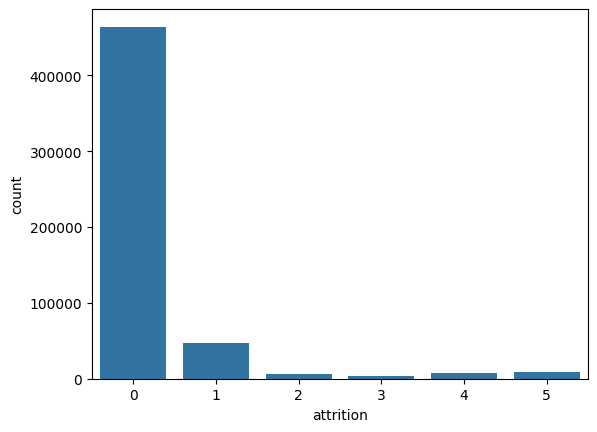

In [5]:
sns.countplot(data = universe_train, x = 'attrition')

Debemos generar las predicciones para el universo de test.

In [6]:
universe_test.head()

,ID,period
0,20b427c65c62ee0177adfa300bbf9f93ba2e46c86d5bc7...,period_9
1,4881d4a2146002a02279bedb6f0a844af022b4dd1d8b1b...,period_9
2,28ff12351f215091b54166a09ca44858f3d7f6245f281c...,period_9
3,5cd2c0dc92c1c5ffa83a94f15756cef5c58174e9d8c69a...,period_9
4,ceebdd2bbaafd83d8c205e8071b79da5338e9db94c9509...,period_9


## 2. Customer

Contiene datos sociodemográficos; también, de tenencia de productos y ofertas en el banco.

La función siguiente permite leer los datos y transformar las columnas categóricas a numéricas.

In [7]:
def varCustomer():
    # Leer la base
    df_customers = pd.read_csv('bbva-data-challenge-2023/archive/customers.csv')
    
    # Columnas binarias
    for col_ in ['product_1', 'product_2', 'product_3', 'product_4', 'ofert_1', 'ofert_2', 'ofert_3']:
        df_customers[col_] = df_customers[col_].apply(lambda x: 1 if x=='Yes' else 0)
        
    # Generar dummies
    df_customers = pd.get_dummies(df_customers, columns = ['type_job', 'bureau_risk'], dtype=int)
    
    return df_customers

In [8]:
df_customers = varCustomer()

In [9]:
df_customers.head()

,ID,age,income,time_from_specialized,payroll,product_1,product_2,product_3,product_4,ofert_1,...,type_job_type_7,bureau_risk_category_1,bureau_risk_category_2,bureau_risk_category_3,bureau_risk_category_4,bureau_risk_category_5,bureau_risk_category_6,bureau_risk_category_7,bureau_risk_category_8,bureau_risk_category_9
0,42af3bf64c2c14307361e970e76c9653df78b215838971...,4.2484,4.1259,0.0,4.8095,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,5ab9acd6dc30e0e9361ca53e797b40f68841bd698d0926...,4.6903,3.9570,0.0,0.0000,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,8e40f988dd93417a0a40c32e65386425d891c879fedf4c...,4.1682,4.4640,0.0,0.0000,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0e48974ce6e81d9e81a8da780521a2f98fb2385dc879df...,3.9651,4.0966,0.0,0.0000,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,0
4,e033c53b4fb230de5da6868503a9e079b289e064d62de4...,3.9576,4.1876,0.0,0.0000,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


# 3. Balances - RCC

Contiene los datos de los saldo de crédito del Reporte Crediticio Consolidado.

In [10]:
df_balance = pd.read_csv('bbva-data-challenge-2023/archive/balances.csv')

In [11]:
df_balance.head()

,month,ID,type,product,entity,balance_amount,days_default,period
0,11,c844ef92b32ec94baaf565a3d22cfa20fd1544a0f8efab...,type_7,product_2,entity_2,3.4051,5.0,period_5
1,10,c817cb3a37a6b640304e87fafd7cd8569bfffb650a5aa3...,type_7,product_2,entity_1,3.4003,5.0,period_5
2,6,1d1f726d844c5a343cca1bbfd0c2b869559f5910772c5e...,type_7,product_2,entity_5,3.0592,5.0,period_5
3,6,7c77a3fd230db16988cb2e6ca23779c756f86895dfe254...,type_7,product_2,entity_2,2.8013,5.0,period_5
4,11,a8702fb4fbdcb735619d6fbd0a5fed46096cdaba80ea35...,type_7,product_2,entity_2,2.9850,5.0,period_5


Función para la creación de variables de la fuente de balance.

In [12]:
def varRCCPivot(df_balance, historia, pivot, cal = 'mean'):
    """
    df_balance: base de RCC
    historia: cantidad de meses para la historia (máximo 12)
    pivot: columna para el pivot
    cal: cálculo a realizar a las variables numéricas
    """
    # Pivot
    dfRCCVar = pd.pivot_table(df_balance[df_balance['month'] >= 12 - historia + 1], 
                                   index=['ID', 'period'], 
                                   columns=[pivot], 
                                   values=['balance_amount', 'days_default'], 
                                   aggfunc=cal, 
                                   fill_value=0)
    # Renombrar
    dfRCCVar.columns = [x[1]+'_' + x[0] + '_' +cal + '_' + str(historia) for x in dfRCCVar.columns]
    dfRCCVar.reset_index(inplace = True)
    
    return dfRCCVar

## Ejemplo

Cálculo del promedio de los últimos 12 meses de los tipos de crédito.

In [13]:
dfRccTypeMean12 = varRCCPivot(df_balance, 12, 'type', cal = 'mean')

In [14]:
dfRccTypeMean12

,ID,period,type_1_balance_amount_mean_12,type_2_balance_amount_mean_12,type_3_balance_amount_mean_12,type_4_balance_amount_mean_12,type_5_balance_amount_mean_12,type_7_balance_amount_mean_12,type_1_days_default_mean_12,type_2_days_default_mean_12,type_3_days_default_mean_12,type_4_days_default_mean_12,type_5_days_default_mean_12,type_7_days_default_mean_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0,0.0,3.190333,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,0.0,0.0,3.394012,0.0,0.000000,0.0,0.0,0.0,0.07855,0.0,0.000000,0.0
2,000095b7b77ff622b2130f2d4bfa1e8d81f1fc4580a248...,period_5,0.0,0.0,2.385600,0.0,0.000000,0.0,0.0,0.0,5.00000,0.0,0.000000,0.0
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,0.0,0.0,3.313423,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,0.0,0.0,3.614636,0.0,4.985392,0.0,0.0,0.0,0.20000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505692,ffff4968b6af50790f53a2c1385ba6a11e6b9d4a1e72f3...,period_1,0.0,0.0,3.553517,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
505693,ffff8c53a19d67e0651f65209b1072de29ccb82117e08a...,period_2,0.0,0.0,3.011675,0.0,0.000000,0.0,0.0,0.0,1.25000,0.0,0.000000,0.0
505694,ffff94ddba5c7e3396b55a61b5720354aee91c399ef461...,period_6,0.0,0.0,3.642755,0.0,4.973550,0.0,0.0,0.0,0.00000,0.0,0.165200,0.0
505695,ffff9f3da8cd310697f907aa774b0290feb277472345b2...,period_6,0.0,0.0,3.539545,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0


## Ejemplo

Cálculo del promedio de los últimos 12 meses por productos.

In [15]:
dfRccProductMean12 = varRCCPivot(df_balance, 12, 'product', cal = 'mean')

In [16]:
dfRccProductMean12.head()

,ID,period,product_1_balance_amount_mean_12,product_2_balance_amount_mean_12,product_3_balance_amount_mean_12,product_4_balance_amount_mean_12,product_5_balance_amount_mean_12,product_6_balance_amount_mean_12,product_7_balance_amount_mean_12,product_1_days_default_mean_12,product_2_days_default_mean_12,product_3_days_default_mean_12,product_4_days_default_mean_12,product_5_days_default_mean_12,product_6_days_default_mean_12,product_7_days_default_mean_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.000000,3.190333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,3.611722,2.740880,0.0,0.0,0.0,0.000000,0.0,0.104733,0.0,0.0,0.0,0.0,0.0,0.0
2,000095b7b77ff622b2130f2d4bfa1e8d81f1fc4580a248...,period_5,2.385600,0.000000,0.0,0.0,0.0,0.000000,0.0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,3.313423,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,3.586342,4.293700,0.0,0.0,0.0,4.985392,0.0,0.000000,5.0,0.0,0.0,0.0,0.0,0.0


# 4. Ahorros

Datos de los saldos de ahorro de los clientes.

In [17]:
df_liabilities = pd.read_csv('bbva-data-challenge-2023/archive/liabilities.csv')

In [18]:
df_liabilities.head()

,month,ID,product_1,product_2,period
0,11,c7a6cecac361a970ee6c7cb9f2679c38c668940c6ebdc5...,4.1900,0.0,period_5
1,12,68f89dc7efe7cd1ce3cf6d52d8867bd2b84f236736bf91...,4.4621,0.0,period_5
2,2,e3f6afb18792d0b97cb9a63ad9567bbd106146c78d212a...,4.2878,0.0,period_5
3,1,8993170400939d522bdc72707527f5ab90202119fe3cab...,5.0000,5.0,period_5
4,7,399d686897232a55c713d61a6bdc7e232ab85b864d6288...,3.8922,0.0,period_5


Función para la creación de variables de la fuente de ahorros.

In [19]:
def varLiabilities(df_liabilities, historia, dict_cal):
    """
    df_liabilities: base de ahorros
    historia: cantidad de meses para la historia (máximo 12)
    dict_cal: diccionario con los cálculos a realizar a las variables numéricas
    """
    
    dfVarLiabilities = df_liabilities[df_liabilities['month'] >= 12 - historia + 1].groupby(['ID', 'period'])\
                        .agg(
                            dict_cal
                        )

    dfVarLiabilities.columns = [ 'pas_'+ x[1]+'_' + x[0] + '_' + str(historia) for x in dfVarLiabilities.columns]

    dfVarLiabilities.reset_index(inplace = True)
    
    return dfVarLiabilities

Diccionario con los cálculos a realizar a las variables numéricas.

In [20]:
liabilities_dict = {
                        'product_1': ['min', 'mean', 'max', 'median', 'var'],
                        'product_2': ['min', 'mean', 'max', 'median', 'var'],
                        'month': ['count']
                    }

## Ejemplo

Cálculo de las variables de ahorro en los últimos 6 meses de datos.

In [21]:
dfVarLiabilities6 = varLiabilities(df_liabilities, 6, liabilities_dict)

In [22]:
dfVarLiabilities6.head()

,ID,period,pas_min_product_1_6,pas_mean_product_1_6,pas_max_product_1_6,pas_median_product_1_6,pas_var_product_1_6,pas_min_product_2_6,pas_mean_product_2_6,pas_max_product_2_6,pas_median_product_2_6,pas_var_product_2_6,pas_count_month_6
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.4939,1.949500,3.4815,1.98965,1.656339,0.000,0.0000,0.0000,0.0000,0.00000,6
1,000043cc1abd7597c99f494cc523ff99a4e0e64e98b128...,period_1,2.7086,3.132133,3.5701,3.07850,0.113414,0.073,0.6128,3.1542,0.1124,1.55034,6
2,000095b7b77ff622b2130f2d4bfa1e8d81f1fc4580a248...,period_5,3.9865,3.986500,3.9865,3.98650,0.000000,0.000,0.0000,0.0000,0.0000,0.00000,6
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,4.0464,4.099767,4.2115,4.08685,0.003466,0.000,0.0000,0.0000,0.0000,0.00000,6
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,2.6543,2.996833,3.9150,2.88050,0.211022,0.000,0.0000,0.0000,0.0000,0.00000,6


# 5. Compras

Posee los datos de las compras realizas con la tarjeta del banco en 4 rubros de comercios.

In [23]:
df_movements = pd.read_csv('bbva-data-challenge-2023/archive/movements.csv')

In [24]:
df_movements.head()

,period,ID,month,type_1,type_2,type_3,type_4
0,period_9,a66d4bbb5278c8a586e03d81e1be8d3590060d8f37fb8c...,12,0.0000,0.0000,0.0000,3.9437
1,period_9,0d0a4fb4f1c98add65a45cf8882e1d81848502143f4ae2...,1,3.7397,3.3499,0.0000,0.0000
2,period_9,a5b9c4d7ae3dfe5cc1c0ca073b0cb0369e1389bfec5c56...,4,3.6273,3.9726,3.6655,4.4131
3,period_9,8a583965c827c377690b816c90246eaedc499f03a5f25f...,8,3.7855,4.8286,5.0000,4.5094
4,period_9,e53bf4249c7d6d573d532b8b0bad7ffe2fb203a4f00675...,7,2.6077,3.9344,1.3229,3.8061


Función para la creación de variables de compras.

In [25]:
def varMovements(df_movements, historia, dict_cal):
    """
    df_movements: base de compras
    historia: cantidad de meses para la historia (máximo 12)
    dict_cal: diccionario con los cálculos a realizar a las variables numéricas
    """
    dfVarMovements = df_movements[df_movements['month'] >= 12 - historia + 1].groupby(['ID', 'period'])\
                        .agg(
                            dict_cal
                        )

    dfVarMovements.columns = [ 'mov_'+ x[1]+'_' + x[0] + '_' + str(historia) for x in dfVarMovements.columns]

    dfVarMovements.reset_index(inplace = True)
    
    return dfVarMovements

Diccionario con los cálculos a realizar a las variables numéricas.

In [26]:
dic_movements = {
                    'type_1': ['min', 'mean', 'max', 'sum'],
                    'type_2': ['min', 'mean', 'max', 'sum'],
                    'type_3': ['min', 'mean', 'max', 'sum'],
                    'type_4': ['min', 'mean', 'max', 'sum'],
                    'month': ['count']
                }

# Ejemplo

Cálculo de las variables de compras en los últimos 12 meses de datos.

In [27]:
dfVarMovements12 = varMovements(df_movements, 12, dic_movements)

In [28]:
dfVarMovements12.head()

,ID,period,mov_min_type_1_12,mov_mean_type_1_12,mov_max_type_1_12,mov_sum_type_1_12,mov_min_type_2_12,mov_mean_type_2_12,mov_max_type_2_12,mov_sum_type_2_12,mov_min_type_3_12,mov_mean_type_3_12,mov_max_type_3_12,mov_sum_type_3_12,mov_min_type_4_12,mov_mean_type_4_12,mov_max_type_4_12,mov_sum_type_4_12,mov_count_month_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0000,1.123000,2.2460,2.2460,0.0,0.0000,0.0000,0.0000,0.0,0.000000,0.0000,0.0000,0.0,1.306700,2.6134,2.6134,2
1,000043cc1abd7597c99f494cc523ff99a4e0e64e98b128...,period_1,0.0000,1.014900,2.0298,2.0298,0.0,0.0000,0.0000,0.0000,0.0,1.711350,3.4227,3.4227,0.0,0.000000,0.0000,0.0000,2
2,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,0.0000,0.483617,2.9017,2.9017,0.0,0.0000,0.0000,0.0000,0.0,2.439500,3.4955,14.6370,0.0,2.582583,3.3280,15.4955,6
3,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,3.2138,3.813633,5.0000,11.4409,0.0,1.1299,3.3897,3.3897,0.0,1.340067,4.0202,4.0202,0.0,0.000000,0.0000,0.0000,3
4,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,0.0000,0.574020,2.8701,2.8701,0.0,1.1580,2.9725,5.7900,0.0,0.480020,2.4001,2.4001,0.0,1.102720,2.8355,5.5136,5


# 6. Digital

Posee los datos de la navegación de los clientes en las plataformas digitales del banco.

In [29]:
df_digital = pd.read_csv('bbva-data-challenge-2023/digital.csv')

In [30]:
df_digital.head()

,month,ID,dig_1,dig_2,dig_3,dig_4,dig_5,dig_6,dig_7,dig_8,dig_9,dig_10,dig_11,period
0,9,bdc817ca1b6ba0deb42d70bee75e4a4e1a1df5d3c9578c...,0.7329,2.2512,2.9029,3.8084,3.0466,3.2779,0.0000,1.0905,2.2750,0.0000,1.7480,period_9
1,3,7474e915adcf95e11cd85fe1dcb660fee704697ae31f87...,4.2287,4.6974,2.9029,2.7366,2.2263,4.1667,1.9824,1.0905,1.6208,0.0000,0.9672,period_9
2,11,506ff183d63da44a9106db1202b2b9cc53ca680ddca44d...,1.7268,3.8201,2.7194,2.5198,1.4561,4.2153,4.2105,2.1810,3.6138,0.0000,3.3457,period_9
3,4,f59effceec688938accd3f6b5d0684edb2ad484e7bef40...,0.0326,1.6499,1.6981,3.7114,2.9214,3.0473,0.0000,1.0905,2.2750,1.1569,1.7480,period_9
4,3,a0d7da88c4d28b52afba4f4bfa066356042bb0bfe8be8b...,2.1337,4.0528,3.3814,2.9244,1.3486,4.3069,3.6679,1.7284,3.5024,0.0000,3.2128,period_9


Función para la creación de variables digitales.

In [31]:
def varDigital(df_digital, historia, dict_cal):
    """
    df_digital: base digital
    historia: cantidad de meses para la historia (máximo 12)
    dict_cal: diccionario con los cálculos a realizar a las variables numéricas
    """
    dfVarDigital = df_digital[df_digital['month'] >= 12 - historia + 1].groupby(['ID', 'period'])\
                        .agg(
                            dict_cal
                        )

    dfVarDigital.columns = [ 'dig_'+ x[1]+'_' + x[0] + '_' + str(historia) for x in dfVarDigital.columns]

    dfVarDigital.reset_index(inplace = True)
    
    return dfVarDigital

Diccionario con los cálculos a realizar a las variables numéricas.

In [32]:
dic_digital = {
                'dig_1': ['min', 'mean', 'max', 'sum'],
                'dig_2': ['min', 'mean', 'max', 'sum'],
                'dig_3': ['min', 'mean', 'max', 'sum'],
                'dig_4': ['min', 'mean', 'max', 'sum'],
                'dig_5': ['min', 'mean', 'max', 'sum'],
                'dig_6': ['min', 'mean', 'max', 'sum'],
                'dig_7': ['min', 'mean', 'max', 'sum'],
                'dig_8': ['min', 'mean', 'max', 'sum'],
                'dig_9': ['min', 'mean', 'max', 'sum'],
                'dig_10': ['min', 'mean', 'max', 'sum'],
                'dig_11': ['min', 'mean', 'max', 'sum'],
                'month': ['count']
            }

## Ejemplo


Cálculo de las variables digitales en los últimos 12 meses de datos.

In [33]:
dfVarDigital12 = varDigital(df_digital, 12, dic_digital)

In [34]:
dfVarDigital12.head()

,ID,period,dig_min_dig_1_12,dig_mean_dig_1_12,dig_max_dig_1_12,dig_sum_dig_1_12,dig_min_dig_2_12,dig_mean_dig_2_12,dig_max_dig_2_12,dig_sum_dig_2_12,...,dig_sum_dig_9_12,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12
0,00000f6dd2df6f081ce59cc4490f152e3fd5695de62bd9...,period_6,0.0000,1.267000,3.0905,11.4030,1.0457,3.262133,4.2168,29.3592,...,24.1292,0.0000,0.215422,1.9388,1.9388,0.5703,2.228956,3.9845,20.0606,9
1,00007a4554cd3a350aec583adebe766eb0beef5684f3dd...,period_6,1.4158,3.207900,5.0000,6.4158,3.7489,4.374450,5.0000,8.7489,...,2.4473,1.2233,1.581050,1.9388,3.1621,0.0001,0.772600,1.5451,1.5452,2
2,00009bb00e84af44d1abc86b9fbd155842ffef6cad814d...,period_8,1.4274,2.583880,4.1650,25.8388,1.9321,3.770080,5.0000,37.7008,...,13.5465,0.0000,0.775060,1.8656,7.7506,0.0001,0.646870,1.2835,6.4687,10
3,0000a9728fc57abef25c2fc0424c9c907a5559e7b8b559...,period_5,1.3679,2.867718,5.0000,31.5449,2.6366,3.518500,4.9355,38.7035,...,22.2467,0.0000,0.701127,3.2312,7.7124,0.0001,1.442000,3.5520,15.8620,11
4,0000bb1dfb27cfb704a54c9b395b443461ff80e5dee265...,period_9,0.0487,0.788273,2.7136,8.6710,1.5163,2.790436,4.9344,30.6948,...,25.8005,0.0000,0.166691,1.8336,1.8336,0.0001,1.832082,4.4049,20.1529,11


# 7. Consolidar

Ahora se va a consolidar todas las fuentes en una matriz que servirá como input al modelo predictivo.

In [35]:
def getMatriz(universo = 'train'):
    
    if universo == 'train':
        df_universo = pd.read_csv('bbva-data-challenge-2023/archive/universe_train.csv')
    else:
        df_universo = pd.read_csv('bbva-data-challenge-2023/archive/universe_test.csv')
        
    # Consolidar
    
    # Customer
    consolidado = pd.merge(df_universo, varCustomer(), how='left', on = ['ID'])
    
    # RCC
    consolidado = pd.merge(consolidado, varRCCPivot(df_balance, 12, 'type', cal = 'mean'), how='left', on = ['ID', 'period'])
    consolidado = pd.merge(consolidado, varRCCPivot(df_balance, 12, 'product', cal = 'mean'), how='left', on = ['ID', 'period'])
    consolidado = pd.merge(consolidado, varRCCPivot(df_balance, 6, 'entity', cal = 'mean'), how='left', on = ['ID', 'period'])
    ### pueden añadir más variables
    
    # Liabilities
    consolidado = pd.merge(consolidado, varLiabilities(df_liabilities, 6, liabilities_dict), how='left', on = ['ID', 'period'])
    
    # Movements
    consolidado = pd.merge(consolidado, varMovements(df_movements, 12, dic_movements), how='left', on = ['ID', 'period'])
    
    # Digital
    consolidado = pd.merge(consolidado, varDigital(df_digital, 12, dic_digital), how='left', on = ['ID', 'period'])
    
    return consolidado

Matriz de entrenamiento

In [36]:
matrix_train = getMatriz(universo = 'train')

Matriz de evaluación para el envío

In [37]:
matrix_submit = getMatriz(universo = 'test')

KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
matrix_train.head()

,ID,attrition,period,age,income,time_from_specialized,payroll,product_1,product_2,product_3,product_4,ofert_1,ofert_2,ofert_3,type_job_type_1,type_job_type_2,type_job_type_3,type_job_type_4,type_job_type_5,type_job_type_6,type_job_type_7,bureau_risk_category_1,bureau_risk_category_2,bureau_risk_category_3,bureau_risk_category_4,bureau_risk_category_5,bureau_risk_category_6,bureau_risk_category_7,bureau_risk_category_8,bureau_risk_category_9,type_1_balance_amount_mean_12,type_2_balance_amount_mean_12,type_3_balance_amount_mean_12,type_4_balance_amount_mean_12,type_5_balance_amount_mean_12,type_7_balance_amount_mean_12,type_1_days_default_mean_12,type_2_days_default_mean_12,type_3_days_default_mean_12,type_4_days_default_mean_12,type_5_days_default_mean_12,type_7_days_default_mean_12,product_1_balance_amount_mean_12,product_2_balance_amount_mean_12,product_3_balance_amount_mean_12,product_4_balance_amount_mean_12,product_5_balance_amount_mean_12,product_6_balance_amount_mean_12,product_7_balance_amount_mean_12,product_1_days_default_mean_12,product_2_days_default_mean_12,product_3_days_default_mean_12,product_4_days_default_mean_12,product_5_days_default_mean_12,product_6_days_default_mean_12,product_7_days_default_mean_12,entity_1_balance_amount_mean_6,entity_2_balance_amount_mean_6,entity_3_balance_amount_mean_6,entity_4_balance_amount_mean_6,entity_5_balance_amount_mean_6,entity_1_days_default_mean_6,entity_2_days_default_mean_6,entity_3_days_default_mean_6,entity_4_days_default_mean_6,entity_5_days_default_mean_6,pas_min_product_1_6,pas_mean_product_1_6,pas_max_product_1_6,pas_median_product_1_6,pas_var_product_1_6,pas_min_product_2_6,pas_mean_product_2_6,pas_max_product_2_6,pas_median_product_2_6,pas_var_product_2_6,pas_count_month_6,mov_min_type_1_12,mov_mean_type_1_12,mov_max_type_1_12,mov_sum_type_1_12,mov_min_type_2_12,mov_mean_type_2_12,mov_max_type_2_12,mov_sum_type_2_12,mov_min_type_3_12,mov_mean_type_3_12,mov_max_type_3_12,mov_sum_type_3_12,mov_min_type_4_12,mov_mean_type_4_12,mov_max_type_4_12,mov_sum_type_4_12,mov_count_month_12,dig_min_dig_1_12,dig_mean_dig_1_12,dig_max_dig_1_12,dig_sum_dig_1_12,dig_min_dig_2_12,dig_mean_dig_2_12,dig_max_dig_2_12,dig_sum_dig_2_12,dig_min_dig_3_12,dig_mean_dig_3_12,dig_max_dig_3_12,dig_sum_dig_3_12,dig_min_dig_4_12,dig_mean_dig_4_12,dig_max_dig_4_12,dig_sum_dig_4_12,dig_min_dig_5_12,dig_mean_dig_5_12,dig_max_dig_5_12,dig_sum_dig_5_12,dig_min_dig_6_12,dig_mean_dig_6_12,dig_max_dig_6_12,dig_sum_dig_6_12,dig_min_dig_7_12,dig_mean_dig_7_12,dig_max_dig_7_12,dig_sum_dig_7_12,dig_min_dig_8_12,dig_mean_dig_8_12,dig_max_dig_8_12,dig_sum_dig_8_12,dig_min_dig_9_12,dig_mean_dig_9_12,dig_max_dig_9_12,dig_sum_dig_9_12,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12
0,4d5a33701cb5b30b0b0a924d80de4ae78fbd0b54e2117f...,0,period_5,3.8498,4.6527,0.000,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,3.669900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.6699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.889,0.00000,3.596867,0.0000,0.0,0.0,0.0,0.0,0.0,2.6140,3.057650,3.3906,3.06710,0.064500,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.052800,3.7176,7.3696,0.0,1.009771,3.7699,7.0684,0.0,1.891729,3.5967,13.2421,0.0000,1.203443,3.3964,8.4241,7.0,0.6284,2.643333,3.7364,31.7200,2.8983,3.621258,4.2102,43.4551,2.2580,2.936917,3.3641,35.2430,1.9496,2.506033,4.4694,30.0724,0.7368,1.287467,2.1622,15.4496,3.4358,4.345892,4.7805,52.1507,2.0380,3.465133,4.5441,41.5816,1.0515,2.768450,4.3849,33.2214,2.8221,3.585450,4.0788,43.0254,0.0,1.484033,2.9024,17.8084,2.3975,3.321883,3.8992,39.8626,12.0
1,bf7092e5f394d266143dfe90b3fc73eac51f0b0084d7a3...,0,period_5,4.5476,4.2447,4.274,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,4.355558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.355558,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,4.52895,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,3.225

In [ ]:
# matrix_train = matrix_train.dropna()

# 8. Seleccionar X e y

El objetivo es generar las bases de train - test para el entrenamiento de datos.

In [ ]:
from sklearn.model_selection import train_test_split

Variables que no se considerarán en el modelos

In [ ]:
columnas_eliminar = ['ID', 'attrition', 'period']

Seleccionar X e Y

In [ ]:
X = matrix_train.drop(columnas_eliminar, axis=1).copy()
y = matrix_train['attrition'].copy()

Partición aleatoria en train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

# 9.Modelo LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

In [ ]:
train_data_lgb = lgb.Dataset(X_train, label=y_train)
test_data_lgb = lgb.Dataset(X_test, label=y_test)

Parámetros de lightgbm, para mayor información revisar: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
params_k = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class': 6,
            'subsample': 0.95,
            'learning_rate': 0.01,
            'max_depth': 5,
            'num_leaves': 100,
            'feature_fraction': 0.9,
            #'max_bin': 100,
            'is_unbalance': True,
            #'boost_from_average': False,
            "random_seed":42,
            'verbose': -1
}

Entrenamiento

In [ ]:
# model = lgb.train(params_k,
#                        train_data_lgb,
#                        valid_sets=[test_data_lgb, train_data_lgb],
#                        num_boost_round=1000,
#                        early_stopping_rounds=100, verbose_eval=50
#                  )
model = lgb.train(params_k,
                       train_data_lgb,
                       valid_sets=[test_data_lgb, train_data_lgb],
                       num_boost_round=1000
                 )

Gráfica de variables importantes

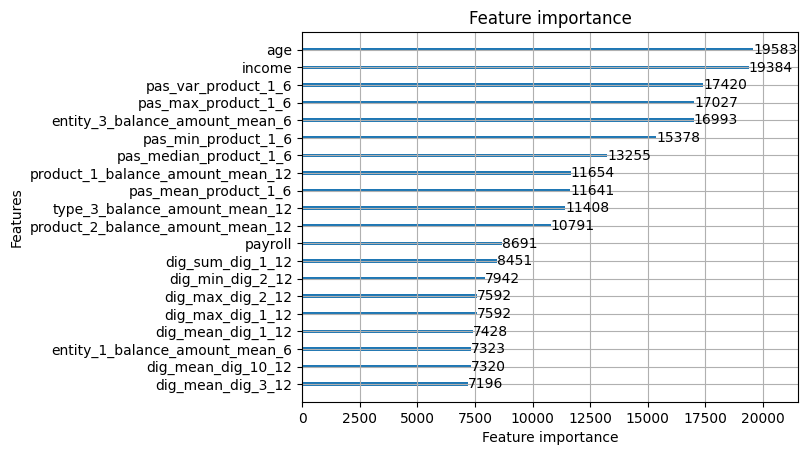

In [ ]:
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

Predicción de train y test

In [ ]:
prediccion_lgb_test = model.predict(X_test, num_iteration=model.best_iteration)
prediccion_lgb_train = model.predict(X_train, num_iteration=model.best_iteration)

Medición del F1

In [ ]:
print('train', f1_score(y_train, np.argmax(prediccion_lgb_train, axis=1), average='macro'))
print('test ', f1_score(y_test, np.argmax(prediccion_lgb_test, axis=1), average='macro'))

train 0.46644317312143735
test  0.2462492407273743


Predicciones para el envío

In [ ]:
prediccion_lgb_submit = model.predict(matrix_submit[X_train.columns], num_iteration=model.best_iteration)

Recordar el formato del archivo de envío.

In [ ]:
submit = matrix_submit[['period', 'ID']].copy()

In [ ]:
submit['target'] = np.argmax(prediccion_lgb_submit, axis=1)

In [ ]:
submit.head()

,period,ID,target
0,period_9,20b427c65c62ee0177adfa300bbf9f93ba2e46c86d5bc7...,0
1,period_9,4881d4a2146002a02279bedb6f0a844af022b4dd1d8b1b...,0
2,period_9,28ff12351f215091b54166a09ca44858f3d7f6245f281c...,0
3,period_9,5cd2c0dc92c1c5ffa83a94f15756cef5c58174e9d8c69a...,0
4,period_9,ceebdd2bbaafd83d8c205e8071b79da5338e9db94c9509...,0


Archivo para el envío

In [ ]:
submit.to_csv('submit_benchmark.csv', index=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dividir tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Calcular el puntaje F1
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Puntaje F1: {f1}')

# Opcional: Visualizar la importancia de las características
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Importancia de características")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
X

,age,income,time_from_specialized,payroll,product_1,product_2,product_3,product_4,ofert_1,ofert_2,ofert_3,type_job_type_1,type_job_type_2,type_job_type_3,type_job_type_4,type_job_type_5,type_job_type_6,type_job_type_7,bureau_risk_category_1,bureau_risk_category_2,bureau_risk_category_3,bureau_risk_category_4,bureau_risk_category_5,bureau_risk_category_6,bureau_risk_category_7,bureau_risk_category_8,bureau_risk_category_9,type_1_balance_amount_mean_12,type_2_balance_amount_mean_12,type_3_balance_amount_mean_12,type_4_balance_amount_mean_12,type_5_balance_amount_mean_12,type_7_balance_amount_mean_12,type_1_days_default_mean_12,type_2_days_default_mean_12,type_3_days_default_mean_12,type_4_days_default_mean_12,type_5_days_default_mean_12,type_7_days_default_mean_12,product_1_balance_amount_mean_12,product_2_balance_amount_mean_12,product_3_balance_amount_mean_12,product_4_balance_amount_mean_12,product_5_balance_amount_mean_12,product_6_balance_amount_mean_12,product_7_balance_amount_mean_12,product_1_days_default_mean_12,product_2_days_default_mean_12,product_3_days_default_mean_12,product_4_days_default_mean_12,product_5_days_default_mean_12,product_6_days_default_mean_12,product_7_days_default_mean_12,entity_1_balance_amount_mean_6,entity_2_balance_amount_mean_6,entity_3_balance_amount_mean_6,entity_4_balance_amount_mean_6,entity_5_balance_amount_mean_6,entity_1_days_default_mean_6,entity_2_days_default_mean_6,entity_3_days_default_mean_6,entity_4_days_default_mean_6,entity_5_days_default_mean_6,pas_min_product_1_6,pas_mean_product_1_6,pas_max_product_1_6,pas_median_product_1_6,pas_var_product_1_6,pas_min_product_2_6,pas_mean_product_2_6,pas_max_product_2_6,pas_median_product_2_6,pas_var_product_2_6,pas_count_month_6,mov_min_type_1_12,mov_mean_type_1_12,mov_max_type_1_12,mov_sum_type_1_12,mov_min_type_2_12,mov_mean_type_2_12,mov_max_type_2_12,mov_sum_type_2_12,mov_min_type_3_12,mov_mean_type_3_12,mov_max_type_3_12,mov_sum_type_3_12,mov_min_type_4_12,mov_mean_type_4_12,mov_max_type_4_12,mov_sum_type_4_12,mov_count_month_12,dig_min_dig_1_12,dig_mean_dig_1_12,dig_max_dig_1_12,dig_sum_dig_1_12,dig_min_dig_2_12,dig_mean_dig_2_12,dig_max_dig_2_12,dig_sum_dig_2_12,dig_min_dig_3_12,dig_mean_dig_3_12,dig_max_dig_3_12,dig_sum_dig_3_12,dig_min_dig_4_12,dig_mean_dig_4_12,dig_max_dig_4_12,dig_sum_dig_4_12,dig_min_dig_5_12,dig_mean_dig_5_12,dig_max_dig_5_12,dig_sum_dig_5_12,dig_min_dig_6_12,dig_mean_dig_6_12,dig_max_dig_6_12,dig_sum_dig_6_12,dig_min_dig_7_12,dig_mean_dig_7_12,dig_max_dig_7_12,dig_sum_dig_7_12,dig_min_dig_8_12,dig_mean_dig_8_12,dig_max_dig_8_12,dig_sum_dig_8_12,dig_min_dig_9_12,dig_mean_dig_9_12,dig_max_dig_9_12,dig_sum_dig_9_12,dig_min_dig_10_12,dig_mean_dig_10_12,dig_max_dig_10_12,dig_sum_dig_10_12,dig_min_dig_11_12,dig_mean_dig_11_12,dig_max_dig_11_12,dig_sum_dig_11_12,dig_count_month_12
0,3.8498,4.6527,0.0000,0.0000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,3.669900,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3.669900,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.889000,0.000000,3.596867,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,2.6140,3.057650,3.3906,3.06710,0.064500,0.0000,0.000000,0.0000,0.00000,0.000000,6.0,0.0000,1.052800,3.7176,7.3696,0.0000,1.009771,3.7699,7.0684,0.0,1.891729,3.5967,13.2421,0.0000,1.203443,3.3964,8.4241,7.0,0.6284,2.643333,3.7364,31.7200,2.8983,3.621258,4.2102,43.4551,2.2580,2.936917,3.3641,35.2430,1.9496,2.506033,4.4694,30.0724,0.7368,1.287467,2.1622,15.4496,3.4358,4.345892,4.7805,52.1507,2.0380,3.465133,4.5441,41.5816,1.0515,2.768450,4.3849,33.2214,2.8221,3.585450,4.0788,43.0254,0.0000,1.484033,2.9024,17.8084,2.3975,3.321883,3.8992,39.8626,12.0
4,4.3077,4.3285,0.0000,0.0000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,3.725000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3.725000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.357400,0.000000,0.000000,0.000000,0.0,0.000

In [ ]:
pd.set_option('display.max_rows', None)
obtener_resumen_valores_unicos(X)

,Columna,Tipo de Dato,Valores Únicos,Total Valores,Valores Nulos
0,age,float64,13327,217800,0
1,income,float64,11075,217800,0
2,time_from_specialized,float64,16619,217800,0
3,payroll,float64,17130,217800,0
4,product_1,int64,2,217800,0
5,product_2,int64,2,217800,0
6,product_3,int64,2,217800,0
7,product_4,int64,2,217800,0
8,ofert_1,int64,2,217800,0
9,ofert_2,int64,2,217800,0


In [ ]:
pd.reset_option('display.max_rows')